In [55]:
from pathlib import Path

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pickle

In [56]:
# Constants

## ROOT
DATA_ROOT_PATH = Path("../data/")

## W1 D1
DATA_W1_D1_PATH = DATA_ROOT_PATH / "qsd1_w1"
GT_DATA_W1_D1_PATH = DATA_W1_D1_PATH / "gt_corresps.pkl"
assert DATA_W1_D1_PATH.exists()
assert GT_DATA_W1_D1_PATH.exists()

## DATABASE

DATABASE_PATH = DATA_ROOT_PATH / "BBDD"
RELATIONSHIPS_DATABASE_PATH = DATABASE_PATH / "relationships.pkl"
assert DATABASE_PATH.exists()
assert RELATIONSHIPS_DATABASE_PATH.exists()

In [75]:
with GT_DATA_W1_D1_PATH.open('rb') as f:
    gt_data_w1_d1_list = pickle.load(f)

len(gt_data_w1_d1_list)

30

In [58]:
# Query image descriptors

database_image_descriptors = []
for database_image_path in DATABASE_PATH.glob("*.jpg"):
    database_image = Image.open(database_image_path).convert('L')
    histogram, bin_edges = np.histogram(database_image, bins=256, range=(0, 255))
    histogram = histogram / histogram.sum()
    database_image_descriptors.append(histogram)
database_image_descriptors = np.array(database_image_descriptors)

In [59]:
# Database descriptors

query_image_descriptors = []
for query_image_path in DATA_W1_D1_PATH.glob("*.jpg"):
    query_image = Image.open(query_image_path).convert('L')
    histogram, bin_edges = np.histogram(query_image, bins=256, range=(0, 255))
    histogram = histogram / histogram.sum()
    query_image_descriptors.append(histogram)
query_image_descriptors = np.array(query_image_descriptors)

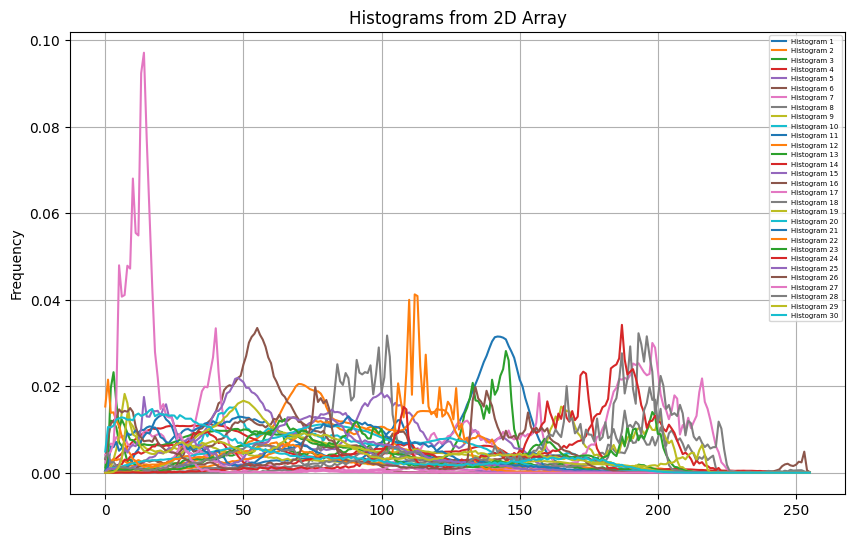

In [76]:
# Create a plot for each histogram in the array
bins = np.arange(query_image_descriptors.shape[1])
plt.figure(figsize=(10, 6))
for i, hist in enumerate(query_image_descriptors):
    plt.plot(bins, hist, label=f'Histogram {i+1}')

# Labeling the plot
plt.title('Histograms from 2D Array')
plt.xlabel('Bins')
plt.ylabel('Frequency')
plt.legend(fontsize=5)
plt.grid(True)

# Show the plot
plt.show()

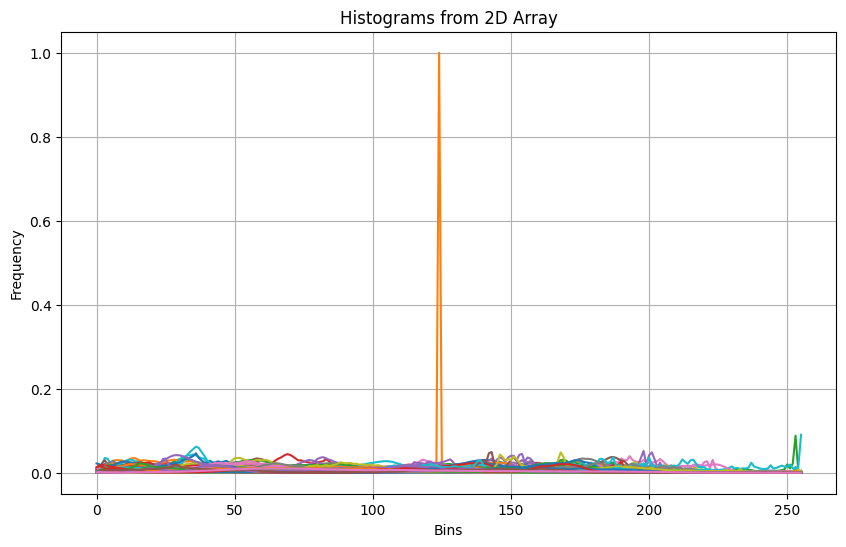

In [78]:
# Create a plot for each histogram in the array
bins = np.arange(database_image_descriptors.shape[1])
plt.figure(figsize=(10, 6))
for i, hist in enumerate(database_image_descriptors):
    plt.plot(bins, hist)

# Labeling the plot
plt.title('Histograms from 2D Array')
plt.xlabel('Bins')
plt.ylabel('Frequency')
plt.grid(True)

# Show the plot
plt.show()

In [61]:
def compute_mse(query_image_descriptors, database_image_descriptors, K):
    # Number of query images and database images
    num_query_images = query_image_descriptors.shape[0]
    num_database_images = database_image_descriptors.shape[0]

    # To store indices of K closest images for each query image
    closest_indices = []

    # Iterate through each query image descriptor
    for query_descriptor in query_image_descriptors:
        # Compute MSE between query descriptor and each database descriptor
        mse_values = np.mean((database_image_descriptors - query_descriptor) ** 2, axis=1)
        
        # Get indices of the K smallest MSE values
        closest_k_indices = np.argsort(mse_values)[:K].tolist()
        
        # Append the indices of the K closest images
        closest_indices.append(closest_k_indices)

    return closest_indices

In [62]:
K = 1  # Number of closest images to retrieve

# Get the indices of K closest images
closest_indices = compute_mse(query_image_descriptors, database_image_descriptors, K)
print(closest_indices)

[[120], [109], [104], [227], [4], [92], [50], [258], [117], [63], [136], [274], [131], [232], [8], [103], [36], [36], [32], [174], [241], [87], [214], [18], [282], [7], [71], [234], [86], [133]]


In [69]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def classification_metrics(groundtruth, predictions):
    # Flatten the list of lists to simple lists
    y_true = [item[0] for item in groundtruth]
    y_pred = [item[0] for item in predictions]

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    # Return the computed metrics
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

In [73]:
for x, y in zip(closest_indices, gt_data_w1_d1_list):
    print(x, y)

[120] [120]
[109] [170]
[104] [277]
[227] [227]
[4] [251]
[92] [274]
[50] [285]
[258] [258]
[117] [117]
[63] [203]
[136] [192]
[274] [22]
[131] [113]
[232] [101]
[8] [174]
[103] [155]
[36] [270]
[36] [47]
[32] [286]
[174] [215]
[241] [262]
[87] [245]
[214] [257]
[18] [182]
[282] [262]
[7] [38]
[71] [238]
[234] [67]
[86] [86]
[133] [133]


In [70]:
# Compute the metrics
metrics = classification_metrics(gt_data_w1_d1_list, closest_indices)
print(metrics)

{'accuracy': 0.2, 'precision': np.float64(0.12), 'recall': np.float64(0.12), 'f1_score': np.float64(0.12)}


C:\Users\gerar\Documents\CVM\C1\code\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gerar\Documents\CVM\C1\code\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [80]:
import numpy as np

def knn_distances(A, B):
    # A is of shape (N, K)
    # B is of shape (M, K)

    # Step 1: Compute the squared sum of A and B
    A_squared = np.sum(A**2, axis=1).reshape(-1, 1)  # Shape (N, 1)
    B_squared = np.sum(B**2, axis=1).reshape(1, -1)  # Shape (1, M)

    # Step 2: Compute the dot product between A and B (A * B^T)
    AB_dot = np.dot(A, B.T)  # Shape (N, M)

    # Step 3: Calculate the distance matrix
    dists_squared = A_squared + B_squared - 2 * AB_dot
    dists = np.sqrt(dists_squared)  # Element-wise square root
    
    return dists

# Example usage:
A = np.array([[1, 2], [3, 4], [5, 6]])  # Shape (3, 2)
B = np.array([[1, 0], [0, 1], [1, 1], [99, 99], [1, 2], [3, 4], [5, 6]])  # Shape (3, 2)

distances = knn_distances(A, B)
print(distances)


[[  2.           1.41421356   1.         137.88763541   0.
    2.82842712   5.65685425]
 [  4.47213595   4.24264069   3.60555128 135.05924626   2.82842712
    0.           2.82842712]
 [  7.21110255   7.07106781   6.40312424 132.23085873   5.65685425
    2.82842712   0.        ]]


In [81]:
import numpy as np

def knn_l1_distances(A, B):
    # A is of shape (N, K)
    # B is of shape (M, K)

    # Broadcasting the absolute difference, then summing along the feature axis
    # Add a new axis to A and B to make their shapes compatible for broadcasting
    dists = np.sum(np.abs(A[:, np.newaxis, :] - B[np.newaxis, :, :]), axis=2)
    
    return dists

# Example usage:
A = np.array([[1, 2], [3, 4], [5, 6]])  # Shape (3, 2)
B = np.array([[1, 0], [0, 1], [1, 1], [1, 2], [3, 4], [5, 6]])  # Shape (3, 2)

distances = knn_l1_distances(A, B)
print(distances)


[[ 2  2  1  0  4  8]
 [ 6  6  5  4  0  4]
 [10 10  9  8  4  0]]
